# Importación de las librerías necesarias para la ejecución #

In [1]:
#Librerias Necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
#from sklearn.preprocessing import scale

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import KFold, cross_val_score, cross_validate

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score, make_scorer
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix

from scipy.stats import f_oneway
from scipy.stats import kendalltau, spearmanr
from scipy.stats import pointbiserialr

# Lectura de los datos de los partidos ya formateados en .csv

In [2]:
import os

dataframes = []
carpeta = "Datos_Formateados/"  # Reemplaza "ruta/de/la/carpeta" con la ruta de la carpeta que deseas explorar

archivos = os.listdir(carpeta)
for archivo in archivos:
    df = pd.read_csv("Datos_Formateados/"+archivo)
    dataframes.append(df)

datos_partidos = pd.concat(dataframes, ignore_index=True)

temporadas = datos_partidos.groupby('season')
dataframes = []
for nombre_grupo, temporada_df in temporadas:
    dataframes.append(temporada_df)
dataframes = [dataframes[0]] 

print(datos_partidos.shape)
print(len(dataframes))

(26299, 12)
1


In [3]:
datos_partidos.fillna(0, inplace=True)
datos_partidos.shape

(26299, 12)

In [4]:
datos_partidos.head()

,Unnamed: 0,game_id,season,type,date_time_GMT,home_team_id,away_team_id,home_goals,away_goals,outcome,home_wins,overtime
0,18399,2000020001,20002001,R,2000-10-04T23:00:00Z,25,21,2,2,tbc win OT,0.0,0.0
1,18040,2000020005,20002001,R,2000-10-05T23:00:00Z,20,17,3,4,away win REG,0.0,0.0
2,18043,2000020003,20002001,R,2000-10-05T23:00:00Z,7,16,4,2,home win REG,1.0,0.0
3,18311,2000020004,20002001,R,2000-10-05T23:00:00Z,4,23,6,3,home win REG,1.0,0.0
4,19132,2000020002,20002001,R,2000-10-05T23:00:00Z,6,9,4,4,tbc win OT,0.0,0.0


In [5]:
def get_equipos(dataframe: pd.DataFrame) -> list:
    team_list = []
    for idx in dataframe.index:
        if dataframe['home_team_id'][idx] not in team_list:
            team_list.append(dataframe['home_team_id'][idx])
        if dataframe['away_team_id'][idx] not in team_list:
            team_list.append(dataframe['away_team_id'][idx])
    return team_list

equipos = get_equipos(dataframe=datos_partidos)
len(equipos)

36

# Predicción del ganador de un partido 

## - Pre-procesamiento de los datos ##

### Obtención del gol average medio de cada partido

In [6]:
def get_goles_marcados_por_partido(dataframe: pd.DataFrame, equipo: str) -> list:
    lista_goles_por_partido = []
    partidos_del_equipo = dataframe.loc[(dataframe['home_team_id'] == equipo) | (dataframe['away_team_id'] == equipo)]
    for idx, partido in partidos_del_equipo.iterrows():
        if partido['home_team_id'] == equipo:
            lista_goles_por_partido.append(partido['home_goals'])
        if partido['away_team_id'] == equipo:
            lista_goles_por_partido.append(partido['away_goals'])
    return lista_goles_por_partido

def get_goles_encajados_por_partido(dataframe: pd.DataFrame, equipo: str) -> list:
    lista_goles_por_partido = []
    partidos_del_equipo = dataframe.loc[(dataframe['home_team_id'] == equipo) | (dataframe['away_team_id'] == equipo)]
    for idx, partido in partidos_del_equipo.iterrows():
        if partido['home_team_id'] == equipo:
            lista_goles_por_partido.append(partido['away_goals'])
        if partido['away_team_id'] == equipo:
            lista_goles_por_partido.append(partido['home_goals'])
    return lista_goles_por_partido

def obtencion_porteria_a_cero_dataframe(dataframe: pd.DataFrame, guardar: bool) -> list:
    lista_listas_porterias_a_0 = []
    equipos = get_equipos(dataframe=dataframe)
    for equipo in equipos:
        lista_porterias_a_0_por_equipo = []
        porterias_a_0 = 0
        lista_goles_encajados_por_partido = get_goles_encajados_por_partido(dataframe=dataframe, equipo=equipo)
        for goles_encajados in lista_goles_encajados_por_partido:
            if goles_encajados == 0:
                porterias_a_0 += 1
            lista_porterias_a_0_por_equipo.append(porterias_a_0)
        lista_porterias_a_0_por_equipo.insert(0,0)
        if guardar:
            dict_ultimo_porterias_a_0_equipo[equipo] = lista_porterias_a_0_por_equipo[-1]
        lista_porterias_a_0_por_equipo.pop()
        lista_listas_porterias_a_0.append(lista_porterias_a_0_por_equipo)
    return lista_listas_porterias_a_0

def get_media_goles_marcados_por_partido(dataframe: pd.DataFrame, equipo: str) -> list:
    lista_goles_por_partido = get_goles_marcados_por_partido(dataframe=dataframe, equipo=equipo)
    lista_media_goles_por_partido = []
    goles_acumulados = 0
    for idx, valor in enumerate(lista_goles_por_partido):
        lista_media_goles_por_partido.append((valor + goles_acumulados) / (idx+1))
        goles_acumulados += valor
    return lista_media_goles_por_partido

def get_media_goles_encajados_por_partido(dataframe: pd.DataFrame, equipo: str) -> list:
    lista_goles_por_partido = get_goles_encajados_por_partido(dataframe=dataframe, equipo=equipo)
    lista_media_goles_por_partido = []
    goles_acumulados = 0
    # añadir que si ve que el año de la temporada es distinto a uno previo goles acumulados = 0 para que cada temporada se reinicie
    for idx, valor in enumerate(lista_goles_por_partido):
        lista_media_goles_por_partido.append((valor + goles_acumulados) / (idx+1))
        goles_acumulados += valor
    return lista_media_goles_por_partido

def get_media_gol_average_por_partido(dataframe: pd.DataFrame, equipo: str) -> list:
    lista_goles_marcados_por_partido = get_goles_marcados_por_partido(dataframe=dataframe, equipo=equipo)
    lista_goles_encajados_por_partido = get_goles_encajados_por_partido(dataframe=dataframe, equipo=equipo)
    lista_media_gol_average_por_partido = []
    valor_acumulado = 0
    for idx, valor in enumerate(lista_goles_marcados_por_partido):
        lista_media_gol_average_por_partido.append((valor - lista_goles_encajados_por_partido[idx] + valor_acumulado) / (idx+1))
        valor_acumulado += (valor - lista_goles_encajados_por_partido[idx])
    return lista_media_gol_average_por_partido

def obtencion_gol_average_dataframe(dataframe: pd.DataFrame, guardar: bool) -> list:
    lista_listas_gol_average_medio_cada_equipo = []
    equipos = get_equipos(dataframe=dataframe)
    for equipo in equipos:
        lista_gol_average_medio_un_equipo = get_media_gol_average_por_partido(dataframe=dataframe, equipo=equipo)
        lista_gol_average_medio_un_equipo.insert(0,0)
        if guardar:
            dict_ultimo_gol_average_equipo[equipo] = lista_gol_average_medio_un_equipo[-1]
        lista_gol_average_medio_un_equipo.pop()
        lista_listas_gol_average_medio_cada_equipo.append(lista_gol_average_medio_un_equipo)
    return lista_listas_gol_average_medio_cada_equipo
        
def get_diferencia_media_gol_average_por_partido(dataframe: pd.DataFrame, equipo: str) -> list:
    lista_media_gol_average_por_partido = get_media_gol_average_por_partido(dataframe=dataframe, equipo=equipo)
    lista_diferencias = []
    valor_anterior = 0
    for valor in lista_media_gol_average_por_partido:
        lista_diferencias.append(valor - valor_anterior)
        valor_anterior = valor
    return lista_diferencias

def obtencion_diferencias_average_dataframe(dataframe: pd.DataFrame, guardar: bool) -> list:
    lista_listas_diferencias_gol_average_medio_cada_equipo = []
    equipos = get_equipos(dataframe=dataframe)
    for equipo in equipos:
        lista_diferencias_gol_average_medio_un_equipo = get_diferencia_media_gol_average_por_partido(dataframe=dataframe, equipo=equipo)
        lista_diferencias_gol_average_medio_un_equipo.insert(0,0)
        if guardar:
            dict_ultimas_diferencias_cada_equipo[equipo] = lista_diferencias_gol_average_medio_un_equipo[-1]
        lista_diferencias_gol_average_medio_un_equipo.pop()
        lista_listas_diferencias_gol_average_medio_cada_equipo.append(lista_diferencias_gol_average_medio_un_equipo)
    return lista_listas_diferencias_gol_average_medio_cada_equipo

def get_puntos_en_liga_equipo(dataframe: pd.DataFrame, equipo: str) -> list:
    lista_puntos_por_partido = []
    puntos = 0
    partidos_equipo = dataframe.loc[(dataframe['home_team_id'] == equipo) | (dataframe['away_team_id'] == equipo)]
    for idx, partido in partidos_equipo.iterrows():
        resultado = partido['home_wins']
        overtime = partido['overtime']
        if partido['home_team_id'] == equipo and resultado == 1:
           puntos += 2 
        elif partido['away_team_id'] == equipo and resultado == 0:
           puntos += 2
        elif partido['home_team_id'] == equipo and resultado == 0 and overtime == 1:
           puntos += 1
        elif partido['away_team_id'] == equipo and resultado == 1 and overtime == 1:
           puntos += 1
        else:
            puntos += 0
        lista_puntos_por_partido.append(puntos)
    return lista_puntos_por_partido

def get_resultados_partidos_equipo(dataframe: pd.DataFrame, equipo: str) -> list:
    lista_resultados_equipo = []
    victorias = 0
    derrotas = 0
    partidos_del_equipo = dataframe.loc[(dataframe['home_team_id'] == equipo) | (dataframe['away_team_id'] == equipo)]
    for idx, partido in partidos_del_equipo.iterrows():
        if partido['home_team_id'] == equipo and partido['home_wins'] == 1:
            victorias += 1
        elif partido['away_team_id'] == equipo and partido['home_wins'] == 0:
            victorias += 1
        elif partido['home_team_id'] == equipo and partido['home_wins'] == 0:
            derrotas += 1
        elif partido['away_team_id'] == equipo and partido['home_wins'] == 1:
            derrotas += 1
        lista_resultados_equipo.append((victorias,derrotas))
    return lista_resultados_equipo

def obtencion_resultados_en_liga(dataframe: pd.DataFrame, guardar: bool) -> list:
    lista_listas_resultados_en_liga = []
    equipos = get_equipos(dataframe=dataframe)
    for equipo in equipos:
        lista_resultados_por_partido_un_equipo = get_resultados_partidos_equipo(dataframe=dataframe, equipo=equipo)
        lista_resultados_por_partido_un_equipo.insert(0,(0,0))
        if guardar:
            dict_ultimos_resultados_cada_equipo[equipo] = lista_resultados_por_partido_un_equipo[-1]
        lista_resultados_por_partido_un_equipo.pop()
        lista_listas_resultados_en_liga.append(lista_resultados_por_partido_un_equipo)
    return lista_listas_resultados_en_liga

def obtencion_puntos_en_liga(dataframe: pd.DataFrame, guardar:bool) -> list:
    lista_listas_puntos_en_liga = []
    equipos = get_equipos(dataframe=dataframe)
    for equipo in equipos:
        lista_puntos_por_partido_un_equipo = get_puntos_en_liga_equipo(dataframe=dataframe, equipo=equipo)
        lista_puntos_por_partido_un_equipo.insert(0,0)
        if guardar:
            dict_ultimos_puntos_cada_equipo[equipo] = lista_puntos_por_partido_un_equipo[-1]
        lista_puntos_por_partido_un_equipo.pop()
        lista_listas_puntos_en_liga.append(lista_puntos_por_partido_un_equipo)
    return lista_listas_puntos_en_liga
    
def obtencion_media_goles_marcados(dataframe: pd.DataFrame, guardar:bool) -> list:
    lista_listas_goles_marcados = []
    equipos = get_equipos(dataframe=dataframe)
    for equipo in equipos:
        lista_goles_por_partido_un_equipo = get_media_goles_marcados_por_partido(dataframe=dataframe, equipo=equipo)
        lista_goles_por_partido_un_equipo.insert(0,0)
        if guardar:
            dict_ultimos_goles_marcados_cada_equipo[equipo] = lista_goles_por_partido_un_equipo[-1]
        lista_goles_por_partido_un_equipo.pop()
        lista_listas_goles_marcados.append(lista_goles_por_partido_un_equipo)
    return lista_listas_goles_marcados

def media_ultimos_5_partidos(favor: list, contra: list, idx: int):
    return ((favor[idx]-contra[idx])+(favor[idx-1]-contra[idx-1])+(favor[idx-2]-contra[idx-2])+(favor[idx-3]-contra[idx-3])+(favor[idx-4]-contra[idx-4])) /5

def get_media_gol_average_por_partido_ultimos_5(dataframe: pd.DataFrame, equipo: str) -> list:
    lista_goles_marcados_por_partido = get_goles_marcados_por_partido(dataframe=dataframe, equipo=equipo)
    lista_goles_encajados_por_partido = get_goles_encajados_por_partido(dataframe=dataframe, equipo=equipo)
    lista_media_gol_average_por_partido = []
    valor_acumulado = 0
    for idx, valor in enumerate(lista_goles_marcados_por_partido):
        if idx <= 4:
            lista_media_gol_average_por_partido.append((valor - lista_goles_encajados_por_partido[idx] + valor_acumulado) / (idx+1))
            valor_acumulado += (valor - lista_goles_encajados_por_partido[idx])
        else:
            lista_media_gol_average_por_partido.append(media_ultimos_5_partidos(favor=lista_goles_marcados_por_partido, contra=lista_goles_encajados_por_partido, idx=idx))

    return lista_media_gol_average_por_partido

def obtencion_gol_average_ultimos_5_dataframe(dataframe: pd.DataFrame, guardar: bool) -> list:
    lista_listas_gol_average_medio_cada_equipo = []
    equipos = get_equipos(dataframe=dataframe)
    for equipo in equipos:
        lista_gol_average_medio_un_equipo = get_media_gol_average_por_partido_ultimos_5(dataframe=dataframe, equipo=equipo)
        lista_gol_average_medio_un_equipo.insert(0,0)
        if guardar:
            dict_ultimo_gol_average_ultimos_5_equipo[equipo] = lista_gol_average_medio_un_equipo[-1]
        lista_gol_average_medio_un_equipo.pop()
        lista_listas_gol_average_medio_cada_equipo.append(lista_gol_average_medio_un_equipo)
    return lista_listas_gol_average_medio_cada_equipo
    
def insercion_datos_cada_dataframe(dataframe: pd.DataFrame, lista_listas_gol_average_medio_cada_equipo: list, lista_listas_diferencias_gol_average_medio_cada_equipo: list,
lista_listas_puntos_por_partido: list, lista_listas_goles_marcados_por_partido: list,
lista_listas_resultados_por_partido: list, lista_listas_porterias_a_cero: list, lista_listas_gol_average_ultimos_5_por_partido: list):
    equipos = get_equipos(dataframe=dataframe)
    for idx_equipos,equipo in enumerate(equipos):
        partidos_del_equipo = dataframe.loc[(dataframe['home_team_id'] == equipo) | (dataframe['away_team_id'] == equipo)]
        idx_partidos = 0
        for idx, partido in partidos_del_equipo.iterrows():
            if partido['home_team_id'] == equipo:
                dataframe.at[idx,'Gol_Average_Home'] = lista_listas_gol_average_medio_cada_equipo[idx_equipos][idx_partidos]
                dataframe.at[idx,'Dif_Home'] = lista_listas_diferencias_gol_average_medio_cada_equipo[idx_equipos][idx_partidos]
                dataframe.at[idx,'Puntos_Home'] = lista_listas_puntos_por_partido[idx_equipos][idx_partidos]
                dataframe.at[idx,'Goles_Marcados_Home'] = lista_listas_goles_marcados_por_partido[idx_equipos][idx_partidos]
                dataframe.at[idx,'Victorias_Home'] = lista_listas_resultados_por_partido[idx_equipos][idx_partidos][0]
                dataframe.at[idx,'Derrotas_Home'] = lista_listas_resultados_por_partido[idx_equipos][idx_partidos][1]
                dataframe.at[idx,'Porterias_0_Home'] = lista_listas_porterias_a_cero[idx_equipos][idx_partidos]
                dataframe.at[idx,'Gol_Average_Ultimos_5_Home'] = lista_listas_gol_average_ultimos_5_por_partido[idx_equipos][idx_partidos]
            if partido['away_team_id'] == equipo:
                dataframe.at[idx,'Gol_Average_Away'] = lista_listas_gol_average_medio_cada_equipo[idx_equipos][idx_partidos]
                dataframe.at[idx,'Dif_Away'] = lista_listas_diferencias_gol_average_medio_cada_equipo[idx_equipos][idx_partidos]
                dataframe.at[idx,'Puntos_Away'] = lista_listas_puntos_por_partido[idx_equipos][idx_partidos]
                dataframe.at[idx,'Goles_Marcados_Away'] = lista_listas_goles_marcados_por_partido[idx_equipos][idx_partidos]
                dataframe.at[idx,'Victorias_Away'] = lista_listas_resultados_por_partido[idx_equipos][idx_partidos][0]
                dataframe.at[idx,'Derrotas_Away'] = lista_listas_resultados_por_partido[idx_equipos][idx_partidos][1]
                dataframe.at[idx,'Porterias_0_Away'] = lista_listas_porterias_a_cero[idx_equipos][idx_partidos]
                dataframe.at[idx,'Gol_Average_Ultimos_5_Away'] = lista_listas_gol_average_ultimos_5_por_partido[idx_equipos][idx_partidos]
            idx_partidos += 1
    return dataframe    
    
dict_ultimas_diferencias_cada_equipo = {}    
dict_ultimo_gol_average_equipo = {}
dict_ultimos_puntos_cada_equipo = {}
dict_ultimos_goles_marcados_cada_equipo = {}
dict_ultimos_resultados_cada_equipo = {}
dict_ultimo_porterias_a_0_equipo = {}
dict_ultimo_gol_average_ultimos_5_equipo = {}
guardar=False
for idx,temporada in enumerate(dataframes):
    if idx == (len(dataframes) - 1):
        guardar = True
    lista_listas_gol_average_medio_cada_equipo = obtencion_gol_average_dataframe(dataframe=temporada, guardar=guardar)
    lista_listas_diferencias_gol_average_medio_cada_equipo = obtencion_diferencias_average_dataframe(dataframe=temporada, guardar=guardar)
    lista_listas_puntos_por_partido = obtencion_puntos_en_liga(dataframe=temporada, guardar=guardar)
    lista_listas_goles_marcados_por_partido = obtencion_media_goles_marcados(dataframe=temporada, guardar=guardar)
    lista_listas_resultados_por_partido = obtencion_resultados_en_liga(dataframe=temporada, guardar=guardar)
    lista_listas_porterias_a_cero = obtencion_porteria_a_cero_dataframe(dataframe=temporada, guardar=guardar)
    lista_listas_gol_average_ultimos_5_por_partido = obtencion_gol_average_ultimos_5_dataframe(dataframe=temporada, guardar=guardar)

    dataframe_con_datos_temporada = insercion_datos_cada_dataframe(dataframe=temporada, lista_listas_gol_average_medio_cada_equipo=lista_listas_gol_average_medio_cada_equipo,
                lista_listas_diferencias_gol_average_medio_cada_equipo=lista_listas_diferencias_gol_average_medio_cada_equipo,
                lista_listas_puntos_por_partido=lista_listas_puntos_por_partido,
                lista_listas_goles_marcados_por_partido=lista_listas_goles_marcados_por_partido,
                lista_listas_resultados_por_partido=lista_listas_resultados_por_partido,
                lista_listas_porterias_a_cero=lista_listas_porterias_a_cero,
                lista_listas_gol_average_ultimos_5_por_partido = lista_listas_gol_average_ultimos_5_por_partido)
    dataframes[idx] = dataframe_con_datos_temporada

    
datos_partidos = pd.concat(dataframes)

### Asignación de etiquetas numéricas a los posibles valores de FTR, HomeTeam y AwayTeam

In [7]:
lb_make = LabelEncoder()
datos_partidos['target home_wins'] = lb_make.fit_transform(datos_partidos['home_wins'])
datos_partidos['home_wins'].value_counts()
label_encoder = LabelEncoder()
datos_partidos['labeled Home'] = label_encoder.fit_transform(datos_partidos['home_team_id'])
datos_partidos['labeled Away'] = label_encoder.fit_transform(datos_partidos['away_team_id'])

In [8]:
datos_partidos['home_wins'].value_counts()

home_wins
1.0    602
0.0    476
Name: count, dtype: int64

In [9]:
datos_partidos.head()

,Unnamed: 0,game_id,season,type,date_time_GMT,home_team_id,away_team_id,home_goals,away_goals,outcome,...,Dif_Away,Puntos_Away,Goles_Marcados_Away,Victorias_Away,Derrotas_Away,Porterias_0_Away,Gol_Average_Ultimos_5_Away,target home_wins,labeled Home,labeled Away
0,18399,2000020001,20002001,R,2000-10-04T23:00:00Z,25,21,2,2,tbc win OT,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,24,20
1,18040,2000020005,20002001,R,2000-10-05T23:00:00Z,20,17,3,4,away win REG,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,19,16
2,18043,2000020003,20002001,R,2000-10-05T23:00:00Z,7,16,4,2,home win REG,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,6,15
3,18311,2000020004,20002001,R,2000-10-05T23:00:00Z,4,23,6,3,home win REG,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,3,22
4,19132,2000020002,20002001,R,2000-10-05T23:00:00Z,6,9,4,4,tbc win OT,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,5,8


In [10]:
datos_partidos.shape

(1230, 31)

In [11]:
datos_partidos = datos_partidos.drop(datos_partidos[(datos_partidos['outcome'] == 'tbc win OT') | (datos_partidos['outcome'] == 'tbc win tbc')].index)
datos_partidos.shape

(1078, 31)

In [12]:
datos_locales = datos_partidos.loc[datos_partidos['home_wins'] == 1]  # Obtiene los índices de las primeras 100 filas que cumplen la condición
datos_visitantes = datos_partidos.loc[datos_partidos['home_wins'] == 0]  # Obtiene los índices de las primeras 100 filas que cumplen la condición
print(len(datos_locales))
print(len(datos_visitantes))

dataframes = [datos_visitantes.head(11500), datos_locales.head(11500)]
datos_partidos = pd.concat(dataframes)
datos_partidos = datos_partidos.drop_duplicates()
datos_partidos['home_wins'].value_counts()


602
476


home_wins
1.0    602
0.0    476
Name: count, dtype: int64

In [13]:
datos_partidos.head()

,Unnamed: 0,game_id,season,type,date_time_GMT,home_team_id,away_team_id,home_goals,away_goals,outcome,...,Dif_Away,Puntos_Away,Goles_Marcados_Away,Victorias_Away,Derrotas_Away,Porterias_0_Away,Gol_Average_Ultimos_5_Away,target home_wins,labeled Home,labeled Away
1,18040,2000020005,20002001,R,2000-10-05T23:00:00Z,20,17,3,4,away win REG,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,19,16
6,18232,2000020018,20002001,R,2000-10-06T15:55:00Z,5,18,1,3,away win REG,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,4,17
7,18405,2000020008,20002001,R,2000-10-06T23:00:00Z,15,26,1,4,away win REG,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,14,25
10,18407,2000020010,20002001,R,2000-10-06T23:30:00Z,13,23,3,4,away win OT,...,-3.0,0.0,3.0,0.0,1.0,0.0,-3.0,0,12,22
12,18769,2000020013,20002001,R,2000-10-06T23:30:00Z,28,19,1,4,away win REG,...,-3.0,0.0,1.0,0.0,1.0,0.0,-3.0,0,27,18


In [14]:
equipos_locales = datos_partidos['labeled Home']
equipos_visitantes = datos_partidos['labeled Away']
gol_average_home = datos_partidos['Gol_Average_Home']
gol_average_away = datos_partidos['Gol_Average_Away']
gol_averages = datos_partidos[['Gol_Average_Home','Gol_Average_Away']]
diferencia_home = datos_partidos['Dif_Home']
diferencia_away = datos_partidos['Dif_Away']
diferencias = datos_partidos[['Dif_Home','Dif_Away']]
puntos_home = datos_partidos['Puntos_Home']
puntos_away = datos_partidos['Puntos_Away']
puntos = datos_partidos[['Puntos_Home','Puntos_Away']]
goles_home = datos_partidos['Goles_Marcados_Home']
goles_away = datos_partidos['Goles_Marcados_Away']
goles = datos_partidos[['Goles_Marcados_Home','Goles_Marcados_Away']]
victorias = datos_partidos[['Victorias_Home','Victorias_Away']]
derrotas = datos_partidos[['Derrotas_Home','Derrotas_Away']]
porterias_0_home = datos_partidos['Porterias_0_Home']
porterias_0_away = datos_partidos['Porterias_0_Away']
porterias_0 = datos_partidos[['Porterias_0_Home','Porterias_0_Away']]
columnas_features = ['Gol_Average_Home','Gol_Average_Away','Dif_Home','Dif_Away','Puntos_Home','Puntos_Away','Goles_Marcados_Home','Goles_Marcados_Away',
                     'Victorias_Home','Derrotas_Home','Victorias_Away','Derrotas_Away','Porterias_0_Home','Porterias_0_Away',
                     'Gol_Average_Ultimos_5_Home','Gol_Average_Ultimos_5_Away']
features = datos_partidos[columnas_features]
target = datos_partidos['home_wins']

In [15]:
for column in datos_partidos.columns:
    if datos_partidos[column].dtype != 'object':  # Solo características continuas
        groups = [datos_partidos[datos_partidos['home_wins'] == value][column] for value in datos_partidos['home_wins'].unique()]
        f_stat, p_value = f_oneway(*groups)
        print(f'ANOVA para {column}: F-statistic={f_stat}, p-value={p_value}')

ANOVA para Unnamed: 0: F-statistic=0.05266540630225966, p-value=0.8185321364653966
ANOVA para game_id: F-statistic=0.18099157452956782, p-value=0.6706075496652892
ANOVA para season: F-statistic=nan, p-value=nan
ANOVA para home_team_id: F-statistic=0.7873397079623461, p-value=0.3751040408225943
ANOVA para away_team_id: F-statistic=0.6479208695553499, p-value=0.42103482714817186
ANOVA para home_goals: F-statistic=703.7642405103793, p-value=1.0157257270160315e-119
ANOVA para away_goals: F-statistic=776.2263130672872, p-value=4.6755477030762735e-129
ANOVA para home_wins: F-statistic=inf, p-value=0.0
ANOVA para overtime: F-statistic=0.02832749780300749, p-value=0.8663728094403953
ANOVA para Gol_Average_Home: F-statistic=28.427996525375885, p-value=1.184693579135174e-07
ANOVA para Dif_Home: F-statistic=0.06833594651503222, p-value=0.7938252550671515
ANOVA para Puntos_Home: F-statistic=8.782329675736772, p-value=0.003108572144164339
ANOVA para Goles_Marcados_Home: F-statistic=10.0358199625742

c:\Users\User\OneDrive\Escritorio\TFG\Cosas_TFG\.venv\lib\site-packages\scipy\stats\_stats_py.py:3895: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


ANOVA para target home_wins: F-statistic=inf, p-value=0.0
ANOVA para labeled Home: F-statistic=0.7873397079623461, p-value=0.3751040408225943
ANOVA para labeled Away: F-statistic=0.6479208695553499, p-value=0.42103482714817186


In [16]:
for column in datos_partidos.columns:
    if datos_partidos[column].dtype != 'object':  # Solo características continuas
        correlation, _ = pointbiserialr(datos_partidos[column], datos_partidos['home_wins'])
        print(f'Correlación de punto biserial para {column}: {correlation}')

Correlación de punto biserial para Unnamed: 0: 0.006995938060150558
Correlación de punto biserial para game_id: 0.012968403676637439
Correlación de punto biserial para season: nan
Correlación de punto biserial para home_team_id: 0.02704058649959883
Correlación de punto biserial para away_team_id: 0.02453150152741716
Correlación de punto biserial para home_goals: 0.6288287068857825
Correlación de punto biserial para away_goals: -0.647361929524005
Correlación de punto biserial para home_wins: 1.0
Correlación de punto biserial para overtime: 0.005130884694211076
Correlación de punto biserial para Gol_Average_Home: 0.1604369596248954
Correlación de punto biserial para Dif_Home: -0.007969015673541607
Correlación de punto biserial para Puntos_Home: 0.0899774263601721
Correlación de punto biserial para Goles_Marcados_Home: 0.09612898485571877
Correlación de punto biserial para Victorias_Home: 0.09534974967926764
Correlación de punto biserial para Derrotas_Home: -0.06827890533817221
Correlació

c:\Users\User\OneDrive\Escritorio\TFG\Cosas_TFG\.venv\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [17]:
#target = to_categorical(target)
#target.shape

## - Normalización de los datos

Ahora mismo, los dos predictores son variables categóricas de tipo string. Estos no pueden ser alimentados directamente al modelo ya que podría ocasionar algún error. Antes deben ser procesados y convertidos a un valor númerico fácilmente interpretable por el modelo. Para lograr esto, utilizo la opción del **One-shot encoding**

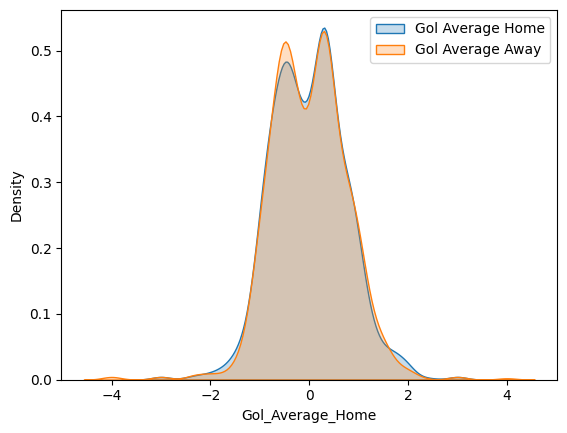

In [18]:
columnas = ['Gol Average Home','Gol Average Away']
for i, col in enumerate(gol_averages.columns):
    sns.kdeplot(gol_averages[col], fill=True, label=columnas[i])
plt.legend()
plt.show()

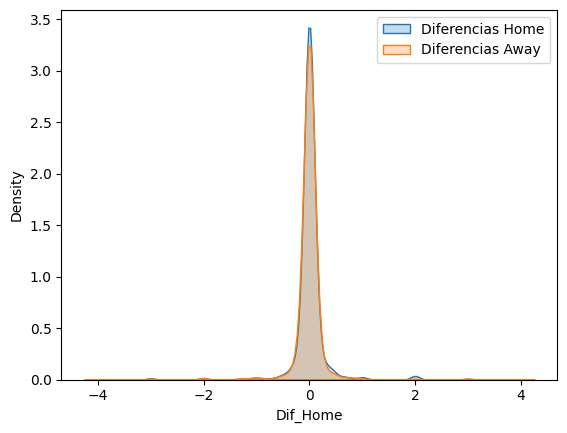

In [19]:
columnas = ['Diferencias Home','Diferencias Away']
for i, col in enumerate(diferencias.columns):
    sns.kdeplot(diferencias[col], fill=True, label=columnas[i])
plt.legend()
plt.show()

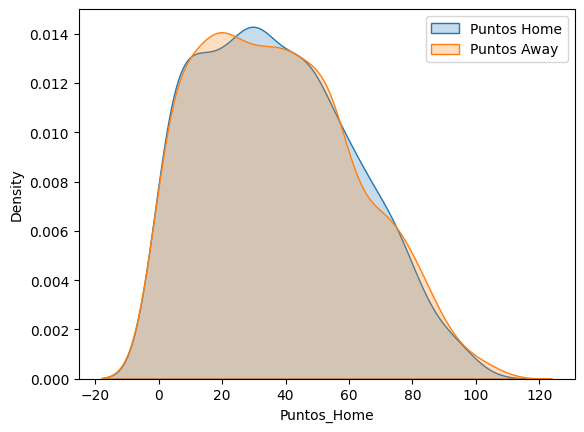

In [20]:
columnas = ['Puntos Home','Puntos Away']
for i, col in enumerate(puntos.columns):
    sns.kdeplot(puntos[col], fill=True, label=columnas[i])
plt.legend()
plt.show()

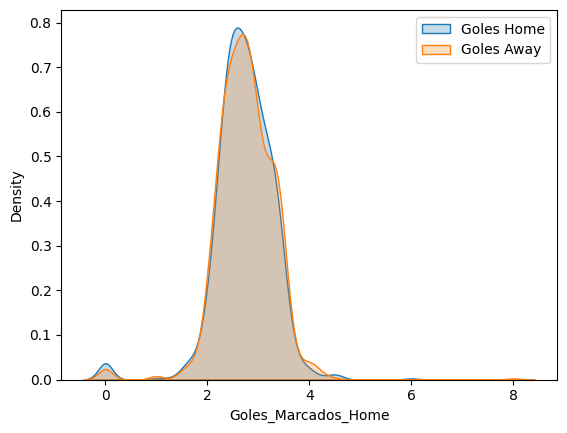

In [21]:
columnas = ['Goles Home','Goles Away']
for i, col in enumerate(goles.columns):
    sns.kdeplot(goles[col], fill=True, label=columnas[i])
plt.legend()
plt.show()

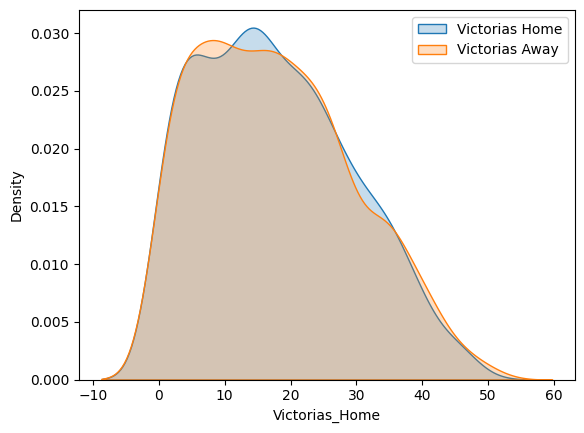

In [22]:
columnas = ['Victorias Home','Victorias Away']
for i, col in enumerate(victorias.columns):
    sns.kdeplot(victorias[col], fill=True, label=columnas[i])
plt.legend()
plt.show()

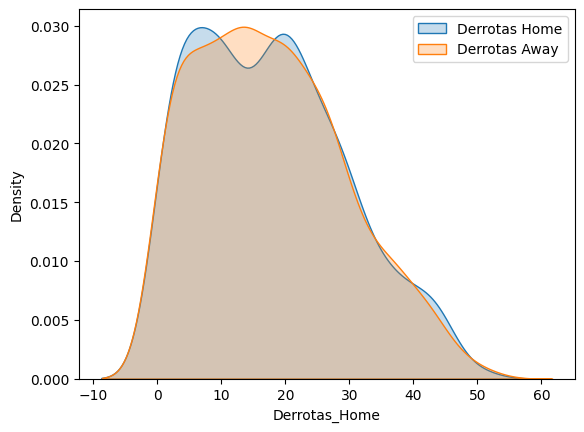

In [23]:
columnas = ['Derrotas Home','Derrotas Away']
for i, col in enumerate(derrotas.columns):
    sns.kdeplot(derrotas[col], fill=True, label=columnas[i])
plt.legend()
plt.show()

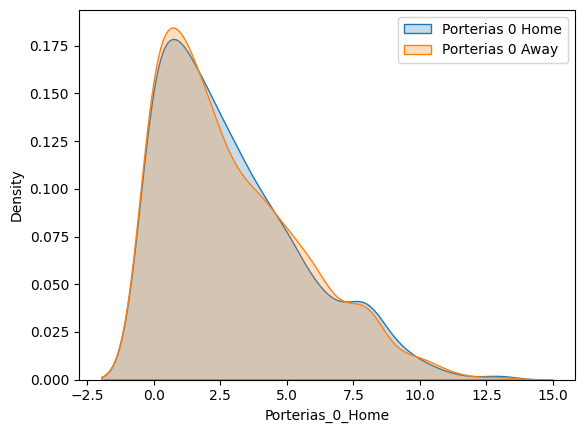

In [24]:
columnas = ['Porterias 0 Home','Porterias 0 Away']
for i, col in enumerate(porterias_0.columns):
    sns.kdeplot(porterias_0[col], fill=True, label=columnas[i])
plt.legend()
plt.show()

In [25]:
scale = MinMaxScaler().fit(features)
features_normalized = scale.transform(features)
features_normalized_dataframe = pd.DataFrame(features_normalized, columns=columnas_features)
features_normalized_dataframe.head()

,Gol_Average_Home,Gol_Average_Away,Dif_Home,Dif_Away,Puntos_Home,Puntos_Away,Goles_Marcados_Home,Goles_Marcados_Away,Victorias_Home,Derrotas_Home,Victorias_Away,Derrotas_Away,Porterias_0_Home,Porterias_0_Away,Gol_Average_Ultimos_5_Home,Gol_Average_Ultimos_5_Away
0,0.5,0.500,0.5,0.500,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.0,0.470588,0.500
1,0.5,0.500,0.5,0.500,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.0,0.470588,0.500
2,0.5,0.500,0.5,0.500,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.0,0.470588,0.500
3,0.5,0.125,0.5,0.125,0.0,0.0,0.0,0.375,0.0,0.0,0.0,0.018868,0.0,0.0,0.470588,0.125
4,0.5,0.125,0.5,0.125,0.0,0.0,0.0,0.125,0.0,0.0,0.0,0.018868,0.0,0.0,0.470588,0.125


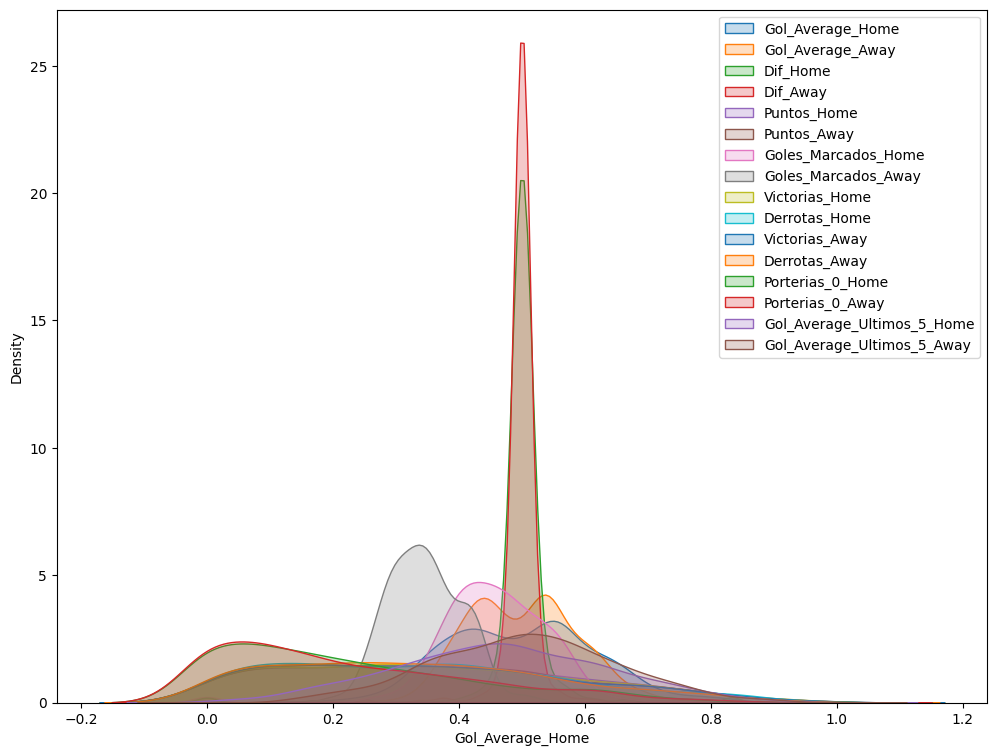

In [26]:
plt.figure(figsize=(12, 9))
for i, col in enumerate(features_normalized_dataframe.columns):
    sns.kdeplot(features_normalized_dataframe[col], fill=True, label=columnas_features[i])
plt.legend()
plt.show()

In [27]:
onehot_encoder = OneHotEncoder(sparse_output=False)
equipos_encoded = onehot_encoder.fit_transform(np.array([equipos_locales, equipos_visitantes]).T)
equipos_encoded.shape

(1078, 60)

In [28]:
#predictores = np.concatenate([gol_average_home,gol_average_away,diferencia_home,diferencia_away,rojas_home,rojas_away], axis=1)
predictores = np.concatenate((features_normalized_dataframe[columnas_features].values, equipos_encoded), axis=1)

In [29]:
predictores.shape

(1078, 76)

In [30]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score, average='macro'),  # Usamos 'macro' para el promedio entre clases
    'precision': make_scorer(precision_score, average='macro')  # Usamos 'macro' para el promedio entre clases
}

## - Entrenamiento del modelo

### División del dataset en entrenamiento y evaluación del modelo

In [31]:
original_feature_names = list(features_normalized_dataframe[columnas_features].columns)

# Nombres de las características categóricas
categorical_feature_names = ['local_team', 'visitor_team']

# Combina ambas listas
all_feature_names = original_feature_names + categorical_feature_names
equipos_locales = np.array(equipos_locales)
equipos_visitantes = np.array(equipos_visitantes)

# Concatenar las características numéricas con las categóricas
predictores_analisis = np.concatenate((features_normalized_dataframe[columnas_features].values, 
                              equipos_locales.reshape(-1, 1), 
                              equipos_visitantes.reshape(-1, 1)), axis=1)

In [32]:
clf = RandomForestClassifier(n_estimators=300, random_state=42, max_depth=7, criterion='log_loss')
selector = SelectFromModel(estimator=clf, threshold='mean') # puedes ajustar el umbral según lo desees
selector.fit(predictores_analisis, target)
predictores_selected = selector.transform(predictores_analisis)
selected_features_mask = selector.get_support()
selected_feature_names = np.array(all_feature_names)[selected_features_mask]

# Mostrar las características seleccionadas
selected_feature_names

array(['Gol_Average_Home', 'Gol_Average_Away', 'Dif_Home', 'Dif_Away',
       'Goles_Marcados_Home', 'Goles_Marcados_Away'], dtype='<U26')

In [33]:
features_train, features_test, target_train, target_test = train_test_split( predictores, target, test_size=0.2, random_state=42)
print ('Train set:', features_train.shape,  target_train.shape)
print ('Test set:', features_test.shape,  target_test.shape)

Train set: (862, 76) (862,)
Test set: (216, 76) (216,)


### Definición y construcción del modelo

In [34]:
def get_modelo_regresion():
    model = LogisticRegression(max_iter=40, solver='liblinear', C=0.1, penalty='l1')
    return model

def get_modelo_random_forest():
    model = RandomForestClassifier(n_estimators=300, random_state=42, max_depth=7, criterion='log_loss')
    return model

def get_modelo_svc():
    model = SVC(kernel='linear', C=0.5, gamma='scale', probability=True)
    return model

def get_modelo_gbm(): ##mejores resultados pero tarda en entrenar
    model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)  
    return model

def get_modelo_decision_tree():
    model = DecisionTreeClassifier(criterion="log_loss",max_depth=13, random_state=42) 
    return model

def get_modelo_knn(): ##mejor recall en empates
    model = KNeighborsClassifier(n_neighbors=47, metric="minkowski", weights='uniform')
    return model

def get_modelo_naive_bayes():
    #model = GaussianNB()
    model = MultinomialNB()
    return model

def get_modelo_regresion_deep(features: pd.DataFrame) -> Sequential:
    numero_predictores = features.shape[1]
    #Crear el modelo
    model = Sequential()
    model.add(Dense(80, activation='relu', input_shape=(numero_predictores,)))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(15, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    
    #Compilar modelo
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])    
    return model

model = get_modelo_random_forest()

### Entrenamiento del modelo

In [35]:
model.fit(features_train, target_train)
#iteraciones=4
#historial_entrenamiento=model.fit(features_train, target_train, validation_data=(features_test,target_test), epochs=iteraciones, verbose=1)

RandomForestClassifier(criterion='log_loss', max_depth=7, n_estimators=300,
                       random_state=42)

In [36]:
results = cross_validate(model, predictores_selected, target, cv=kf, scoring=scoring, return_train_score=False)

## -Evaluación del modelo

### Evolución del modelo

In [37]:
target_pred = model.predict(features_test)
accuracy = accuracy_score(target_test, target_pred)
recal = recall_score(target_test, target_pred, average=None)
recal_total = recall_score(target_test, target_pred, average='macro')
precision = precision_score(target_test, target_pred, average=None)
precision_total = precision_score(target_test, target_pred, average='macro')
conf_matrix = confusion_matrix(target_test, target_pred)
print("Accuracy del modelo:", accuracy)
print("Recall del modelo:", recal)
print("Recall del modelo:", recal_total)
print("Precision del modelo:", precision)
print("Precision del modelo:", precision_total)
print("Matriz de Confusión:")
print(conf_matrix)

Accuracy del modelo: 0.6342592592592593
Recall del modelo: [0.4375     0.79166667]
Recall del modelo: 0.6145833333333333
Precision del modelo: [0.62686567 0.63758389]
Precision del modelo: 0.6322247821296203
Matriz de Confusión:
[[42 54]
 [25 95]]


In [38]:
print("Accuracy por fold:", results['test_accuracy'])
print("Recall por fold:", results['test_recall'])
print("Precision por fold:", results['test_precision'])

print("\nAccuracy medio:", results['test_accuracy'].mean())
print("Recall medio:", results['test_recall'].mean())
print("Precision medio:", results['test_precision'].mean())

print("\nDesviación estándar de Accuracy:", results['test_accuracy'].std())
print("Desviación estándar de Recall:", results['test_recall'].std())
print("Desviación estándar de Precision:", results['test_precision'].std())

Accuracy por fold: [0.63888889 0.60185185 0.58333333 0.52777778 0.53703704 0.59259259
 0.59259259 0.63888889 0.61682243 0.55140187]
Recall por fold: [0.57941176 0.60645604 0.58333333 0.49047619 0.5252838  0.59108062
 0.56942496 0.61684688 0.57186732 0.54429272]
Precision por fold: [0.59876543 0.61285038 0.590301   0.48846154 0.53079179 0.59365079
 0.57638889 0.63314785 0.56693364 0.5488417 ]

Accuracy medio: 0.5881187262028384
Recall medio: 0.5678473629857791
Precision medio: 0.5740133018557662

Desviación estándar de Accuracy: 0.03718756209628949
Desviación estándar de Recall: 0.03629923303293866
Desviación estándar de Precision: 0.04018131449533884


## - Predicción real de un partido

In [39]:
HT=14
AT=17
gol_average_home = dict_ultimo_gol_average_equipo[HT]
gol_average_away = dict_ultimo_gol_average_equipo[AT]
dif_home = dict_ultimas_diferencias_cada_equipo[HT]
dif_away = dict_ultimas_diferencias_cada_equipo[AT]
gol_average5_home = dict_ultimo_gol_average_ultimos_5_equipo[HT]
gol_average5_away = dict_ultimo_gol_average_ultimos_5_equipo[AT]
competition_score_home = dict_ultimos_puntos_cada_equipo[HT]
competition_score_away = dict_ultimos_puntos_cada_equipo[AT]
clean_matches_home = dict_ultimo_porterias_a_0_equipo[HT]
clean_matches_away = dict_ultimo_porterias_a_0_equipo[AT]
victories_home = dict_ultimos_resultados_cada_equipo[HT][0]
victories_away = dict_ultimos_resultados_cada_equipo[AT][0]
derrotas_home = dict_ultimos_resultados_cada_equipo[HT][1]
derrotas_away = dict_ultimos_resultados_cada_equipo[AT][1]
goles_marcados_home = dict_ultimos_goles_marcados_cada_equipo[HT]
goles_marcados_away = dict_ultimos_goles_marcados_cada_equipo[AT]

### Normalizar los predictores teniendo en cuenta los predictores usados para el entrenamiento del modelo

In [40]:
local = [HT,]
visitante = [AT,]
locales_encoded = label_encoder.transform(local)
visitantes_encoded = label_encoder.transform(visitante)

equipos_encoded = onehot_encoder.transform(np.array([locales_encoded, visitantes_encoded]).T)
equipos_encoded.shape

(1, 60)

In [41]:
datos_partido = np.array([
    gol_average_home, gol_average_away,
    dif_home, dif_away,
    competition_score_home, competition_score_away,
    goles_marcados_home, goles_marcados_away,
    victories_home, derrotas_home, victories_away, derrotas_away,
    clean_matches_home, clean_matches_away, gol_average5_home, gol_average5_away
]).reshape(1, -1)
datos_partido = scale.transform(datos_partido)
datos_partido

c:\Users\User\OneDrive\Escritorio\TFG\Cosas_TFG\.venv\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


array([[0.33943089, 0.5777439 , 0.49992472, 0.50058341, 0.50961538,
        0.96226415, 0.40853659, 0.38567073, 0.48      , 1.        ,
        0.96078431, 0.45283019, 0.38461538, 0.23076923, 0.35294118,
        0.6       ]])

In [42]:
predictores = np.concatenate((datos_partido, equipos_encoded), axis=1)
predictores.shape

(1, 76)

### Predicción del valor objetivo

In [43]:
pred = model.predict_proba(predictores)
pred

array([[0.59175777, 0.40824223]])

### Conversión del número devuelto
Puede que el valor de las probabilidades devuelto por el modelo sea muy pequeño así que se opera para ser un número más manejable

In [44]:
def convertir_numbero(prediccion: list) -> list:
    prediccion_valores=[]
    for i in range(len(prediccion[0])):
      pred_number=float(format(prediccion[0][i], '.3f'))
      prediccion_valores.append(pred_number)

    return (prediccion_valores)
  
pred_number_probabilities=convertir_numbero(pred)

### Obtención del resultado predicho en base a las probabilidades predichas por el modelo

In [45]:
def get_ganador_prediccion(ganador: list) -> str:
    y=ganador.index(max(ganador))
    if y==0:
        pred_winner='Away'
    elif y==1:
        pred_winner='Draw'
    else:
        pred_winner='Home'
    return pred_winner

ganador_predicho=get_ganador_prediccion(pred_number_probabilities)

### Resultado Final

In [46]:
#print('El ganador real es: ', ganador_real)
print('El ganador predicho es: ',ganador_predicho)

El ganador predicho es:  Away


### Visualización de las probabilidades en una gráfica

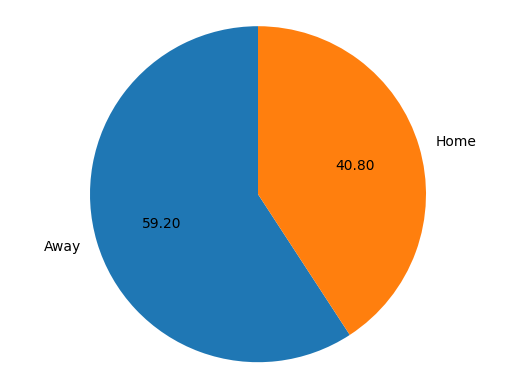

In [47]:
etiquetas = 'Away', 'Home'
figureObject, axesObject = plt.subplots()
axesObject.pie(pred_number_probabilities, labels=etiquetas, autopct='%1.2f', startangle=90)
axesObject.axis('equal') # Aspect ratio equal means pie is a circle
plt.show()